
### Rubina Iman Kabir 


In [1]:
# Packages
import pandas as pd
import random
from sklearn.cluster import KMeans,SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc,accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score, pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelBinarizer,OneHotEncoder
from sklearn.model_selection import KFold,StratifiedKFold

from sklearn.decomposition import PCA

from pandas.plotting import scatter_matrix
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC ,LinearSVC

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

##### (a) Read Data and split into train and test

In [101]:
data = pd.read_csv('wdbc.data',sep=',',header = None)
data.drop(0,axis = 1,inplace=True)

Xdata = pd.DataFrame(MinMaxScaler().fit_transform(data.loc[:,2:]))
Ydata = data[1]

Xpos_data = Xdata[Ydata=='M']
Xpos_data.reset_index(drop = True, inplace=True)
Ypos = Ydata[Ydata=='M']
Ypos.reset_index(drop = True, inplace=True)
pos_data = pd.concat([Xpos_data,Ypos],axis = 1)
pos_data.columns = range(31)

Xneg_data = Xdata[Ydata=='B']
Xneg_data.reset_index(drop = True, inplace=True)
Yneg = Ydata[Ydata=='B']
Yneg.reset_index(drop = True, inplace=True)
neg_data = pd.concat([Xneg_data,Yneg],axis = 1)
neg_data.columns = range(31)

Xtest = pd.concat([neg_data.iloc[0:72,0:30], pos_data.iloc[0:42,0:30]])
Xtest.reset_index(drop=True,inplace=True)
Ytest = pd.concat([neg_data.iloc[0:72,30], pos_data.iloc[0:42,30]])
Ytest.reset_index(drop=True,inplace=True)

Xtrain = pd.concat([neg_data.iloc[72:,0:30], pos_data.iloc[42:,0:30]])
Xtrain.reset_index(drop=True,inplace=True)
Ytrain = pd.concat([neg_data.iloc[72:,30],pos_data.iloc[42:,30]])
Ytrain.reset_index(drop=True,inplace=True)

#### (b) Monte Carlo Simulation

######   (i) Supervised Learning

Training Set Confusion Matrix 

[[283   3]
 [  7 163]]
Test set Confusion Matrix 

[[70  1]
 [ 1 41]]


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Averages
Train Accuracy    0.989108
Precision         0.992427
Recall            0.978235
F1                0.985257
AUC               0.998658
dtype: float64


 Test Averages
Test Accuracy    0.965782
Precision        0.962009
Recall           0.946032
F1               0.953446
AUC              0.988878
dtype: float64


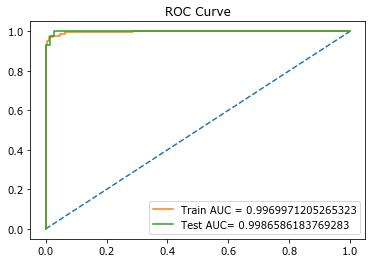

In [91]:
C = np.logspace(-1,3,5)
m = 30
m_train = pd.DataFrame(index = range(m),columns = ['Train Accuracy','Precision','Recall','F1','AUC'])
m_test = pd.DataFrame(index = range(m),columns = ['Test Accuracy','Precision','Recall','F1','AUC'])
r = 0
plot_m = random.randint(0,m)
for M in range(m):
    # Randomly seelct for test
    pos_test = pos_data.sample(frac = 0.2)
    neg_test = neg_data.sample(frac = 0.2)
    test = pd.concat([pos_test,neg_test])
    test.reset_index(drop = True, inplace=True)
    
    m_Xtest = test.loc[:,0:29]
    m_Ytest = np.ravel(test[30].values)
    
    # Set Up training
    pos_train = pos_data.loc[~pos_data.index.isin(pos_test.index)]
    neg_train = neg_data.loc[~neg_data.index.isin(neg_test.index)]
    train = pd.concat([pos_train,neg_train])
    train.reset_index(drop = True, inplace=True)
    
    m_Xtrain = train.loc[:,0:29]
    m_Ytrain = np.ravel(train[30].values)
    acc = []
    for c in C:
        folds = KFold(5).split(m_Xtrain,m_Ytrain)
        cv = 0
        for tr,val in folds:
            svc = LinearSVC(penalty = 'l1',C = c,dual=False,max_iter = 1e5)
            svc.fit(m_Xtrain.loc[tr],m_Ytrain[tr])
            Ypred = svc.score(m_Xtrain.loc[val],m_Ytrain[val])
            cv = cv + Ypred
        acc.append((cv/5,c))
    best_c = max(acc)
    svc = svc = LinearSVC(penalty = 'l1',C = best_c[1],dual=False,max_iter = 1e5)
    svc.fit(m_Xtrain,m_Ytrain)
    
    pred_train = svc.predict(m_Xtrain)
    pred_test = svc.predict(m_Xtest)
    # Accuracy Scores for train and test
    train_score = accuracy_score(m_Ytrain,pred_train)
    test_score = accuracy_score(m_Ytest,pred_test)
    
    # Precision,Recall,f1 scores
    train_precision = precision_score(m_Ytrain,pred_train,pos_label='M')
    train_recall = recall_score(m_Ytrain,pred_train,pos_label='M')
    train_f1 = f1_score(m_Ytrain,pred_train,pos_label='M')
    
    test_precision = precision_score(m_Ytest,pred_test,pos_label = 'M')
    test_recall = recall_score(m_Ytest,pred_test,pos_label = 'M')
    test_f1 = f1_score(m_Ytest,pred_test,pos_label = 'M')
    
    # auc
    train_probs = svc.decision_function(m_Xtrain)
    test_probs = svc.decision_function(m_Xtest)
    train_auc = roc_auc_score(m_Ytrain,train_probs)
    test_auc = roc_auc_score(m_Ytest,test_probs)
    
    m_train.loc[r,:] = [train_score,train_precision,train_recall,train_f1,train_auc]
    m_test.loc[r,:] = [test_score,test_precision,test_recall,test_f1,test_auc]
    r = r + 1

    if M == plot_m:
        tr_fpr,tr_tpr,_ = roc_curve(m_Ytrain, train_probs,pos_label='M')
        
        te_fpr,te_tpr,_ = roc_curve(m_Ytest, test_probs, pos_label = 'M')
        plt.figure()
        plt.plot([0,1],[0,1],linestyle='--')
        plt.plot(tr_fpr,tr_tpr, label='Train AUC = %s'%(train_auc))
        plt.plot(te_fpr, te_tpr,  label = 'Test AUC= %s' % (test_auc))
        plt.legend()
        plt.title('ROC Curve')
        
        train_conf = confusion_matrix(m_Ytrain,pred_train)
        print('Training Set Confusion Matrix \n')
        print(train_conf)
        test_conf = confusion_matrix(m_Ytest,pred_test)
        print('Test set Confusion Matrix \n')
        print(test_conf)
    
print('Train Averages')
print(m_train.mean())
print('\n\n Test Averages')
print(m_test.mean())

On average, the supervised classifier performs the best. The classifier has very little issue in predicting the positive and negative class.

######   (ii) Semi-Supervised Learning

In [112]:
# Normalized training Data
npos_train = Xtrain[Ytrain == 'M']
npos_train.reset_index(drop=True,inplace=True)
temp = Ytrain[Ytrain == 'M']
temp.reset_index(drop=True,inplace=True)
npos_train = pd.concat([npos_train,temp],axis = 1)
npos_train.columns = range(31)

nneg_train = Xtrain[Ytrain == 'B']
nneg_train.reset_index(drop=True,inplace=True)
temp = Ytrain[Ytrain=='B']
temp.reset_index(drop=True,inplace=True)
nneg_train = pd.concat([nneg_train,temp],axis = 1)
nneg_train.columns = range(31)


Training Set Confusion Matrix 

[[283   2]
 [  6 164]]


Test set Confusion Matrix 

[[71  1]
 [ 2 40]]


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




 Train Averages
Accuracy     0.977289
Precision    0.986264
Recall       0.952745
F1           0.969039
AUC          0.993975
dtype: float64 



 Test Averages
Accuracy     0.956140
Precision    0.946687
Recall       0.934921
F1           0.940372
AUC          0.985538
dtype: float64


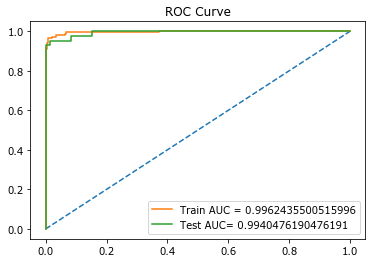

In [111]:
C = np.logspace(-1,3,5)
m = 30
m_train = pd.DataFrame(index = range(m),columns = ['Accuracy','Precision','Recall','F1','AUC'])
m_test = pd.DataFrame(index = range(m),columns = ['Accuracy','Precision','Recall','F1','AUC'])
r = 0
plot_m = random.randint(0,m)
for M in range(m):
    # Randomly seelct for labeled
    pos_train = npos_train.sample(frac = 0.5)
    neg_train = nneg_train.sample(frac = 0.5)
    labeled = pd.concat([pos_train,neg_train])
    labeled.reset_index(drop = True, inplace=True)
    
    m_Xlabeled = labeled.loc[:,0:29]
    m_Ylabeled = np.ravel(labeled.loc[:,30:].values)
    
    # Set Up unlabeled
    pos_unlabeled = npos_train.loc[~npos_train.index.isin(pos_train.index)]
    neg_unlabeled = nneg_train.loc[~nneg_train.index.isin(neg_train.index)]
    unlabeled = pd.concat([pos_unlabeled,neg_unlabeled])
    unlabeled.reset_index(drop = True, inplace=True)
    
    m_Xunlabeled = unlabeled.loc[:,0:29]   
    # Self Label all unlabeled data
    while m_Xunlabeled.shape[0] > 0:
        acc = []
        for c in C:
            folds = KFold(5).split(m_Xlabeled,m_Ylabeled)
            cv = 0
            for tr,val in folds:
                svc = LinearSVC(penalty = 'l1',C = c,dual=False,max_iter = 1e5)
                svc.fit(m_Xlabeled.loc[tr],m_Ylabeled[tr])
                Ypred = svc.score(m_Xlabeled.loc[val],m_Ylabeled[val])
                cv = cv + Ypred
            acc.append((cv/5,c))
        # Find optimal C parameter from CV and use to obtain evaluation metrics
        best_c = max(acc)
        svc = LinearSVC(penalty = 'l1',C = best_c[1],dual=False,max_iter = 1e5)
        svc.fit(m_Xlabeled,m_Ylabeled)
        
        # Find farthest and let svc predict
        distances = svc.decision_function(m_Xunlabeled)
        far_ind = np.argmax(np.abs(distances))
        farthest = m_Xunlabeled.loc[far_ind]
        farthest = np.array(farthest).reshape(1,-1)
        farthest_pred = svc.predict(farthest)
        
        # Add new labeled data point to training set
        add = pd.Series(np.reshape(farthest,-1,1))
        m_Xlabeled = m_Xlabeled.append(add,ignore_index=True)
        m_Ylabeled = np.append(m_Ylabeled,farthest_pred)
        
        # Drop labeled data point from unlabaled data
        m_Xunlabeled = m_Xunlabeled.drop(far_ind)
        m_Xunlabeled.reset_index(drop=True,inplace=True)

    # SVC on entire self-training/labeled dataset
    svc = LinearSVC(penalty = 'l1',C = best_c[1],dual=False,max_iter = 1e5)
    svc.fit(m_Xlabeled,m_Ylabeled)
    
    ######## Calculate metrics ############
    pred_train = svc.predict(Xtrain)
    pred_test = svc.predict(Xtest)
    
    # Accuracy Scores for train and test
    train_score = accuracy_score(Ytrain,pred_train)
    test_score = accuracy_score(Ytest,pred_test)
    
    # Precision,Recall,f1 scores   
    train_precision = precision_score(Ytrain,pred_train,pos_label='M')
    train_recall = recall_score(Ytrain,pred_train,pos_label='M')
    train_f1 = f1_score(Ytrain,pred_train,pos_label='M')
    
    test_precision = precision_score(Ytest,pred_test,pos_label = 'M')
    test_recall = recall_score(Ytest,pred_test,pos_label = 'M')
    test_f1 = f1_score(Ytest,pred_test,pos_label = 'M')
    
    # auc
    train_probs = svc.decision_function(Xtrain)
    test_probs = svc.decision_function(Xtest)
    train_auc = roc_auc_score(Ytrain,train_probs)
    test_auc = roc_auc_score(Ytest,test_probs)
    
    m_train.loc[r,:] = [train_score,train_precision,train_recall,train_f1,train_auc]
    m_test.loc[r,:] = [test_score,test_precision,test_recall,test_f1,test_auc]
    r = r + 1

    if M == plot_m:
        # Plot Roc Curve
        tr_fpr,tr_tpr,_ = roc_curve(Ytrain, train_probs,pos_label='M')   
        te_fpr,te_tpr,_ = roc_curve(Ytest, test_probs, pos_label = 'M')
        plt.figure()
        plt.plot([0,1],[0,1],linestyle='--')
        plt.plot(tr_fpr,tr_tpr, label='Train AUC = %s'%(train_auc))
        plt.plot(te_fpr, te_tpr,  label = 'Test AUC= %s' % (test_auc))
        plt.legend()
        plt.title('ROC Curve')
        
        train_conf = confusion_matrix(Ytrain,pred_train)
        print('Training Set Confusion Matrix \n')
        print(train_conf)
        test_conf = confusion_matrix(Ytest,pred_test)
        print('\n\nTest set Confusion Matrix \n')
        print(test_conf)
    
print('\n\n Train Averages')
print(m_train.mean(),'\n')
print('\n\n Test 3Averages')
print(m_test.mean())
    

The semi-supervised learner performs well on both the training set and test set. Of all algorithms this took the longest because of the self-training. Given the test results, this algorithm is at a close second to the supervised algorithm. 

######   (ii) UnSupervised Learning

In [106]:
ytrain = LabelBinarizer().fit_transform(Ytrain)
ytrain = np.array([item for sublist in ytrain for item in sublist])

ytest = LabelBinarizer().fit_transform(Ytest)
ytest = np.array([item for sublist in ytest for item in sublist])

Training Set Confusion Matrix 

[[284   1]
 [ 25 145]]


Test set Confusion Matrix 

[[67  5]
 [ 8 34]]


 Train Averages
Train Accuracy    0.942857
Precision         0.993151
Recall            0.852941
F1                0.917722
AUC               0.981073
dtype: float64 



 Test Averages
Test Accuracy    0.885965
Precision        0.871795
Recall           0.809524
F1               0.839506
AUC              0.967923
dtype: float64


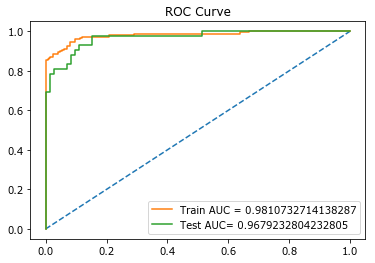

In [107]:
k = 2
m = 30
m_train = pd.DataFrame(index = range(m),columns = ['Train Accuracy','Precision','Recall','F1','AUC'])
m_test = pd.DataFrame(index = range(m),columns = ['Test Accuracy','Precision','Recall','F1','AUC'])
r = 0
plot_m = random.randint(0,m)
for M in range(m):
    km = KMeans(n_clusters = 2, init = 'random').fit(Xtrain)
    
    # Compute cluster centers and get majority poll
    cluster0 = km.cluster_centers_[0]
    dist_c1 = np.sqrt(np.sum(((Xtrain-cluster0)**2),axis = 1))
    cluster1_30 = dist_c1.sort_values().index[0:30]
    cluster1_30 = ytrain[cluster1_30]
    majority0 = np.argmax([np.sum(cluster1_30==0), np.sum(cluster1_30==1)])
    
    cluster1 = km.cluster_centers_[1]
    dist_c2 = np.sqrt(np.sum(((Xtrain-cluster1)**2),axis = 1))
    cluster2_30 = dist_c2.sort_values().index[0:30]
    cluster2_30 = ytrain[cluster2_30]
    majority1 = np.argmax([np.sum(cluster2_30==0), np.sum(cluster2_30==1)])
    
    # Set up dataframe to use in metric calculations
    labels = km.predict(Xtrain)
    true_labeled = pd.DataFrame({0:ytrain,1:labels})
    true_labeled['Majority'] = [None] * Xtrain.shape[0]
    
    mask1 = true_labeled[1] == 0
    true_labeled.loc[mask1,['Majority']] = majority0
    
    mask2 = true_labeled[1] == 1
    true_labeled.loc[mask2,'Majority'] = majority1
    
    # Train Predictions
    pred_train = true_labeled['Majority']
    cluster_distances = km.transform(Xtrain)
    
    sum_clust_dist = np.sum(cluster_distances,axis=1)
    tr_scores = np.array([
        1 - cluster_distances[:,0] / sum_clust_dist,
        1 - cluster_distances[:,1] / sum_clust_dist]).transpose()

    if majority0 == 1 and majority1 == 0:
        tr_scores[:,[1,0]] = tr_scores[:,[0,1]]
    if majority0 == 0 and majority1 == 0:
        tr_scores[:,0] = 1
        tr_scores[:,1] = 0
    elif majority0 == 1 and majority1 == 1:
        tr_scores[:,0] = 0
        tr_scores[:,1] = 1
    
    # Get Test Predicctions
    pred_test = km.predict(Xtest)
    true_labeled = pd.DataFrame({0:ytest,1:pred_test})
    true_labeled['Majority'] = [None] * Xtest.shape[0]
    
    mask1 = true_labeled[1] == 0
    true_labeled.loc[mask1,['Majority']] = majority0
    
    mask2 = true_labeled[1] == 1
    true_labeled.loc[mask2,'Majority'] = majority1
    
    # Test predicstion
    pred_test = true_labeled['Majority']
    dist_c1 = np.sqrt(np.sum(((Xtest-cluster0)**2),axis = 1))
    dist_c2 = np.sqrt(np.sum(((Xtest-cluster1)**2),axis = 1))
    
    cluster_distances = np.stack((dist_c1,dist_c2),axis = -1)
    
    sum_clust_dist = np.sum(cluster_distances,axis=1)
    
    te_scores = np.array([
        1 - cluster_distances[:,0] / sum_clust_dist,
        1 - cluster_distances[:,1] / sum_clust_dist,]).transpose()

    if majority0 == 1 and majority1 == 0:
        te_scores[:,[1,0]] = te_scores[:,[0,1]]
    if majority0 == 0 and majority1 == 0:
        te_scores[:,0] = 1
        te_scores[:,1] = 0
    elif majority0 == 1 and majority1 == 1:
        te_scores[:,0] = 0
        te_scores[:,1] = 1
    # Accuracy Scores for train and test
    train_score = accuracy_score(ytrain,pred_train)
    test_score = accuracy_score(ytest,pred_test)
    
    # Precision,Recall,f1 scores   
    train_precision = precision_score(ytrain,pred_train)
    train_recall = recall_score(ytrain,pred_train)
    train_f1 = f1_score(ytrain,pred_train)
    
    test_precision = precision_score(ytest,pred_test)
    test_recall = recall_score(ytest,pred_test)
    test_f1 = f1_score(ytest,pred_test)
    
    # auc
    train_auc = roc_auc_score(ytrain, tr_scores[:,1])
    test_auc = roc_auc_score(ytest, te_scores[:,1])
    
    m_train.loc[r,:] = [train_score,train_precision,train_recall,train_f1,train_auc]
    m_test.loc[r,:] = [test_score,test_precision,test_recall,test_f1,test_auc]
    r = r + 1

    if M == plot_m:
        tr_fpr,tr_tpr,_ = roc_curve(ytrain, tr_scores[:,1])
        
        te_fpr,te_tpr,_ = roc_curve(ytest, te_scores[:,1])
        plt.figure()
        plt.plot([0,1],[0,1],linestyle='--')
        plt.plot(tr_fpr,tr_tpr, label='Train AUC = %s'%(train_auc))
        plt.plot(te_fpr, te_tpr,  label = 'Test AUC= %s' % (test_auc))
        plt.legend()
        plt.title('ROC Curve')
        
        train_conf = confusion_matrix(ytrain,pred_train)
        print('Training Set Confusion Matrix \n')
        print(train_conf)
        test_conf = confusion_matrix(ytest,pred_test)
        print('\n\nTest set Confusion Matrix \n')
        print(test_conf)
    
print('\n\n Train Averages')
print(m_train.mean(),'\n')
print('\n\n Test Averages')
print(m_test.mean())
    


On average, the unsupervised learner performs well, about 99% accuracy, in predicting the positive class for the training set based on the precision score, versus for the negative class, 85%. For the test set however, the test set also exhibits a similar behavior - 87% for precision and 81% for recall.

To prevent K-means from being trapped at a local minumum, one way is to iterate over ALL possible clusterings and select the model with the best performance. However, this approach is unrealisitic as the number of iterations will increase exponentially as we increase the size of our data.

######   (ii) Spectral Clustering

Training Set Confusion Matrix 

[[285   0]
 [ 66 104]]


Test set Confusion Matrix 

[[69  3]
 [12 30]]


 Train Averages
Train Accuracy    0.854945
Precision         1.000000
Recall            0.611765
F1                0.759124
AUC               0.978861
dtype: float64 



 Test Averages
Train Accuracy    0.868421
Precision         0.909091
Recall            0.714286
F1                0.800000
AUC               0.950340
dtype: float64


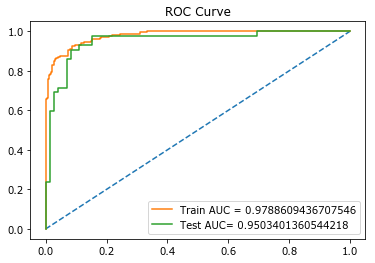

In [110]:
k = 2
m = 30
m_train = pd.DataFrame(index = range(m),columns = ['Train Accuracy','Precision','Recall','F1','AUC'])
m_test = pd.DataFrame(index = range(m),columns = ['Train Accuracy','Precision','Recall','F1','AUC'])
r = 0
plot_m = random.randint(0,m-1)
for M in range(m):
    sc =  SpectralClustering(n_clusters=2, gamma=1.0, affinity="rbf")
    sc.fit(Xtrain)
    # Train set
    labels = sc.labels_
    true_labeled = pd.DataFrame({0:ytrain,1:labels})
    true_labeled['Majority'] = [None] * Xtrain.shape[0]
    
    ind0 = np.argwhere(labels == 0)
    y_0 = ytrain[ind0]
    mask1 = true_labeled[1] == 0
    majority0 = ytrain[mask1]
    majority0 = np.argmax([np.sum(majority0==0), np.sum(majority0==1)])
    true_labeled.loc[mask1,['Majority']] = majority0
    
    ind1 = np.argwhere(labels == 1)
    mask2 = true_labeled[1] == 1
    majority1 = ytrain[mask2]
    majority1 = np.argmax([np.sum(majority1==0), np.sum(majority1==1)])
    true_labeled.loc[mask2,'Majority'] = majority1
    # Train Predictions
    pred_train = true_labeled['Majority']
    tr_dist = pairwise_distances(Xtrain,n_jobs = -1,metric='euclidean')

    for i in range(tr_dist.shape[0]):
        tr_dist[i,i] = np.inf
    tr_min0 = np.amin(tr_dist[:,ind0],axis=1)
    tr_min1 = np.amin(tr_dist[:,ind1],axis=1)

    tr_min0 = tr_min0.reshape(-1,1)
    tr_min1 = tr_min1.reshape(-1,1)
    tr_mins = np.concatenate((tr_min0,tr_min1),axis = 1)

    tr_scores = np.array(
        [
            1 - tr_mins[:, 0] / np.sum(tr_mins, axis=1),
            1 - tr_mins[:, 1] / np.sum(tr_mins, axis=1),
        ]
    ).transpose()

    if majority0 == 1 and majority1 == 0:
        tr_scores[:,[0,1]] = tr_scores[:,[1,0]]
    elif majority0 == 0 and majority1 == 0:
        tr_scores[:,0] = 1
        tr_scores[:,1] = 0
    elif majority0 == 1 and majority1 == 1:
        tr_scores[:,0] = 0
        tr_scores[:,1] = 1

#### # Test Set
    labels = sc.fit_predict(Xtest)
    true_labeled = pd.DataFrame({0:ytest,1:labels})
    true_labeled['Majority'] = [None] * Xtest.shape[0]
    
    ind0 = np.argwhere(labels == 0)
    mask1 = true_labeled[1] == 0
    majority0 = ytest[mask1]
    majority0 = np.argmax([np.sum(majority0==0), np.sum(majority0==1)])
    true_labeled.loc[mask1,['Majority']] = majority0
    
    ind1 = np.argwhere(labels == 1)
    mask2 = true_labeled[1] == 1
    majority1 = ytest[mask2]
    majority1 = np.argmax([np.sum(majority1==0), np.sum(majority1==1)])
    true_labeled.loc[mask2,'Majority'] = majority1
    
    #Test Predictions
    pred_test = true_labeled['Majority']
    te_dist = pairwise_distances(Xtest,n_jobs = -1,metric='euclidean')
    for i in range(te_dist.shape[0]):
        te_dist[i,i] = np.inf
    te_min0 = np.amin(te_dist[:,ind0],axis=1)
    te_min1 = np.amin(te_dist[:,ind1],axis=1)

    te_min0 = te_min0.reshape(-1,1)
    te_min1 = te_min1.reshape(-1,1)

    te_mins = np.concatenate((te_min0,te_min1),axis = 1)
    
    te_scores = np.array([
        1 - te_mins[:,0] / np.sum(te_mins,axis=1),
        1 - te_mins[:,1] / np.sum(te_mins,axis=1)
    ]).transpose()

    if majority0 == 1 and majority1 == 0:
        te_scores[:, [0,1] ] = te_scores[:,[1,0]]
    elif majority0 == 0 and majority1 == 0:
        te_scores[:,0] = 1
        te_scores[:,1] = 0
    elif majority0 == 1 and majority1 == 1:
        te_scores[:,0] = 0
        te_scores[:,1] = 1
    # Accuracy Scores for train and test
    train_score = accuracy_score(ytrain,pred_train)
    test_score = accuracy_score(ytest,pred_test)
    
    # Precision,Recall,f1 scores   
    train_precision = precision_score(ytrain,pred_train)
    train_recall = recall_score(ytrain,pred_train)
    train_f1 = f1_score(ytrain,pred_train)
    
    test_precision = precision_score(ytest,pred_test)
    test_recall = recall_score(ytest,pred_test)
    test_f1 = f1_score(ytest,pred_test)
    
    # auc
    train_auc = roc_auc_score(ytrain[2:],tr_scores[2:,1])
    test_auc = roc_auc_score(ytest[2:],te_scores[2:,1])

    m_train.loc[r,:] = [train_score,train_precision,train_recall,train_f1,train_auc]
    m_test.loc[r,:] = [test_score,test_precision,test_recall,test_f1,test_auc]
    r = r + 1

    if M == plot_m:
        tr_fpr,tr_tpr,_ = roc_curve(ytrain, tr_scores[:,1])
        
        te_fpr,te_tpr,_ = roc_curve(ytest, te_scores[:,1])
        plt.figure()
        plt.plot([0,1],[0,1],linestyle='--')
        plt.plot(tr_fpr,tr_tpr, label='Train AUC = %s'%(train_auc))
        plt.plot(te_fpr, te_tpr,  label = 'Test AUC= %s' % (test_auc))
        plt.legend()
        plt.title('ROC Curve')
        
        train_conf = confusion_matrix(ytrain,pred_train)
        print('Training Set Confusion Matrix \n')
        print(train_conf)
        test_conf = confusion_matrix(ytest,pred_test)
        print('\n\nTest set Confusion Matrix \n')
        print(test_conf)
    
    
print('\n\n Train Averages')
print(m_train.mean(),'\n')
print('\n\n Test Averages')
print(m_test.mean())


The spectral clustering has high precision, and hence has no problem in properly classifying the positive class for both training and test sets. However, it appears to have some confusion with labeling the negative class as it has approximately a recall score of 70% for test set-- the F1 score, appx 80%, represents this balance. 

The high average AUC for the positive class is also represenatative of the clustering having no issue in predicting the positive class.

The accuracy for both test and training set is appx 85%. The method could be improved by using cross-validation to find the gamma that best suits the class imbalance in the original dataset.

##### (v) Compare all algorithms 

Train 


|       Averages   |Supervised  | Semi-Supervised | Unsupervised | Spectral |
| -------- | ---------  | --------------- | ------------ | ---------- | 
| Accuracy |   0.989 |  0.977 |               0.942          | 0.854|
| Precision|    0.992 | 0.986 | 0.993|   1|   
| Recall   | 0.978 | 0.953| 0.852| 0.612| 
| F1-Score | 0.985 | 0.96 | 0.917| 0.759| 
| AUC      | 0.999|0.994|0.98 |  0.977| 



Test

|       Averages   |Supervised  | Semi-Supervised | Unsupervised | Spectral |
| -------- | ---------  | --------------- | ------------ | ---------- | 
| Accuracy |   0.965     |   0.956 | 0.886     | 0.868|
| Precision|  0.962  |0.947  | 0.872| 0.909|   
| Recall   | 0.946|0.935 | 0.809 |  0.714|
| F1-Score | 0.953|  0.940 | 0.839|0.765| 
| AUC      | 0.989 | 0.986| 0.967| 0.950| 





Ranked learning Algorithms based on Test set Accuracy:

    1. Supervised Learning
    2. Semi-Supervised Learning
    3. Unsupervised Learning
    4. Spectral Clustering

## 2. Active Learning using SVM

##### (a) Data

In [100]:
data = pd.read_csv('data_banknote_authentication.txt',header=None)
test = data.sample(472)
train = data.loc[~data.index.isin(test.index)]

train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

Xtrain = train.loc[:,0:3]
Ytrain = train.loc[:,4]

Xtest = test.loc[:,0:3]
Ytest = np.ravel(test.loc[:,4])

##### (b) Monte Carlo 

##### (i) Passive Learning

In [102]:
C = np.logspace(-1,6,5)
m = 50
passive_learning = pd.DataFrame(index=range(m),columns = range(90))
r = 0
cc = []
for M in range(m):
    passive = train.sample(10) 
    yy = passive.loc[:,4]
    
    # Ensure that at least 2 occurances of both classes
    unique, counts = np.unique(yy, return_counts=True)
    check = dict(zip(unique, counts))
    while check[0] < 2 or check[1] < 2:
        passive = train.sample(10)
        yy = passive.loc[:,4]
        unique, counts = np.unique(yy, return_counts=True)
        check = dict(zip(unique, counts))
    # Ensure that at least 2 occurances of both classes
    queue = train.loc[~train.index.isin(passive.index)]
    
    passive.reset_index(inplace=True,drop=True)
    queue.reset_index(inplace=True,drop=True)
    
    Xpassive = passive.loc[:,0:3]
    Ypassive = np.ravel(passive.loc[:,4])
    
    Xq = queue.loc[:,0:3]
    Yq = np.ravel(queue.loc[:,4])
    
    col = 0
    while Xq.shape[0] >= 0 or col <= 89:
        acc = []
        for c in C:
            folds = KFold(10).split(Xpassive,Ypassive)
            cv = 0
            for tr,val in folds:
                svc = LinearSVC(penalty = 'l1',C = c,dual=False,max_iter = 1e5)
                svc.fit(Xpassive.loc[tr],Ypassive[tr])
                Ypred = svc.score(Xpassive.loc[val],Ypassive[val])
                cv = cv + Ypred
        acc.append((cv/10,c))
        cc.append((cv/10,c))
        best_c = max(acc)
        svc = LinearSVC(penalty = 'l1',C = best_c[1],dual=False,max_iter = 1e5)
        svc.fit(Xpassive,Ypassive)
        
        pred_passive = svc.predict(Xpassive)
        pred_test = svc.predict(Xtest)
        
        # Calculate errors
        passive_error = (1 - accuracy_score(Ypassive,pred_passive))
        test_error = (1 - accuracy_score(Ytest,pred_test))
        passive_learning.loc[r,col] = test_error
        col = col + 1
        if Xq.shape[0] == 0:
            break
        # Get next 10 to add
        add = queue.sample(10)
        Xadd = add.loc[:,0:3]
        Yadd = add.loc[:,4]
        queue = queue.drop(add.index)
        
        Xpassive = Xpassive.append(Xadd,ignore_index=True)
        Ypassive = np.append(Ypassive,Yadd)
        
        Xq = queue.loc[:,0:3]
        Yq = queue.loc[:,4]
    
    r = r + 1
        
        
        

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

##### (ii) Active Learning

In [103]:
C = np.logspace(-1,6,5)
m = 50
active_learning = pd.DataFrame(index=range(m),columns = range(90))
r = 0
cc = []
for M in range(m):
    active = train.sample(10) 
    yy = active.loc[:,4]
    
    # Ensure that at least 2 occurances of both classes
    unique, counts = np.unique(yy, return_counts=True)
    check = dict(zip(unique, counts))
    while check[0] < 2 or check[1] < 2:
        print('Need to get sample again')
        active = train.sample(10)
        yy = active.loc[:,4]
        unique, counts = np.unique(yy, return_counts=True)
        check = dict(zip(unique, counts))
    # Ensure that at least 2 occurances of both classes
    queue = train.loc[~train.index.isin(active.index)]
    
    active.reset_index(inplace=True,drop=True)
    queue.reset_index(inplace=True,drop=True)
    
    Xactive = active.loc[:,0:3]
    Yactive = np.ravel(active.loc[:,4])
    
    Xq = queue.loc[:,0:3]
    Yq = np.ravel(queue.loc[:,4])
    
    col = 0
    while Xq.shape[0] >= 0 or col <= 89:
        acc = []
        for c in C:
            folds = KFold(10).split(Xactive,Yactive)
            cv = 0
            for tr,val in folds:
                svc = LinearSVC(penalty = 'l1',C = c,dual=False,max_iter = 1e5)
                svc.fit(Xactive.loc[tr],Yactive[tr])
                Ypred = svc.score(Xactive.loc[val],Yactive[val])
                cv = cv + Ypred
        acc.append((cv/10,c))
        cc.append((cv/10,c))
        best_c = max(acc)
        svc = LinearSVC(penalty = 'l1',C = best_c[1],dual=False,max_iter = 1e5)
        svc.fit(Xactive,Yactive)
        
        pred_active = svc.predict(Xactive)
        pred_test = svc.predict(Xtest)
        
        # Calculate errors
        active_error = (1 - accuracy_score(Yactive,pred_active))
        test_error = (1 - accuracy_score(Ytest,pred_test))
        active_learning.loc[r,col] = test_error
        col = col + 1
        
        if Xq.shape[0] == 0:
            break
        # Get closest 10 to add
        distances = svc.decision_function(Xq)
        distances = list(zip(distances,Xq.index))
        distances = sorted(list(np.abs(distances)),key = lambda tup: tup[0])
        ten = distances[:10]
        inds = [int(x[1]) for x in ten]
        
        add = queue.loc[inds]
        Xadd = add.loc[:,0:3]
        Yadd = add.loc[:,4]
        queue = queue.drop(add.index)
        
        Xactive = Xactive.append(Xadd,ignore_index=True)
        Yactive = np.append(Yactive,Yadd)
        
        Xq = queue.loc[:,0:3]
        Yq = queue.loc[:,4]
    
    r = r + 1

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

Need to get sample again


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

Need to get sample again


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

Need to get sample again


/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rubinakabir/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/svm

##### (c) Learning Curves

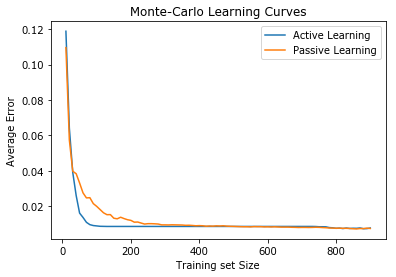

In [104]:
active = active_learning.mean().values
passive = passive_learning.mean().values
sizes = np.arange(10,910,10)

plt.figure()
plt.plot(sizes,active,label='Active Learning')
plt.plot(sizes,passive,label='Passive Learning')
plt.title('Monte-Carlo Learning Curves')
plt.xlabel('Training set Size')
plt.ylabel('Average Error')
plt.legend()

As expected, the active learning implementation outperforms passive learning over the different training set sizes, on average. The error for active learning converges when the training set size is 40 whereas the passive learning curve converges at 220. 